In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re


In [0]:
def Preprocess_text(data):
    data['Title'] = data['Title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Title'] = data['Title'].apply(lambda x: x.lower())
    data['Title'] = data['Title'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    data['Article'] = data['Article'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Article'] = data['Article'].apply(lambda x: x.lower())
    data['Article'] = data['Article'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    data['Author'] = data['Author'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Author'] = data['Author'].apply(lambda x: x.lower())
    data['Author'] = data['Author'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    return data

In [4]:
df = pd.read_csv('/content/drive/My Drive/Fake-News-Detection/dataset/Poltifact_dataset.csv',sep=',',index_col='idx')
df = df.loc[(df.Labels=='Pants on Fire!') | (df.Labels=='TRUE')] # for two labels
df = Preprocess_text(df)

labelencoder = LabelEncoder()
#df['Image'] = labelencoder.inverse_transform(df['Image'])
df['Labels'] = labelencoder.fit_transform(df['Labels'])
print(labelencoder.classes_)
df.head()

['Pants on Fire!' 'TRUE']


,Title,Date,Author,Article,Labels
idx,,,,,
0,no bill cosby wasn t framed for sexual assaul...,"on Monday, November 4th, 2019 at 2:31 p.m.",samantha putterman,actor and comedian bill cosby was convicted...,0
3,kamala harris didn t say democrats are coming...,"on Monday, November 4th, 2019 at 1:03 p.m.",daniel funke,a quote from sen kamala harris attacking su...,0
10,no evidence that cream of tartar and orange ju...,"on Wednesday, October 30th, 2019 at 2:03 p.m.",samantha putterman,quitting smoking is hard over the years ex...,0
11,cnn did not call abu bakr al baghdadi an unar...,"on Wednesday, October 30th, 2019 at 1:07 p.m.",daniel funke,a viral photo of a cnn chyron makes it look ...,0
14,fact check does california really have NUM ...,"on Thursday, October 31st, 2019 at 11:41 a.m.",chris nichols,california s homeless crisis now ranks as on...,1


In [5]:
train_all = df[['Author','Title','Article']]
target_all = df['Labels']
column = df['Title']
print(column[3])
train_all.head()

kamala harris didn t say democrats are  coming for  trump supporters in  NUM 


,Author,Title,Article
idx,,,
0,samantha putterman,no bill cosby wasn t framed for sexual assaul...,actor and comedian bill cosby was convicted...
3,daniel funke,kamala harris didn t say democrats are coming...,a quote from sen kamala harris attacking su...
10,samantha putterman,no evidence that cream of tartar and orange ju...,quitting smoking is hard over the years ex...
11,daniel funke,cnn did not call abu bakr al baghdadi an unar...,a viral photo of a cnn chyron makes it look ...
14,chris nichols,fact check does california really have NUM ...,california s homeless crisis now ranks as on...


In [6]:
%tensorflow_version 2.x
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


max_length = max([len(s.split()) for s in train_all['Article']])
max_length2 = max([len(s.split()) for s in train_all['Title']])
max_length3 = max([len(s.split()) for s in train_all['Author']])
x_train, x_test, y_train, y_test = train_test_split(train_all,target_all, test_size=0.2, random_state=42)
tokenizer = Tokenizer()
tokenizer2 = Tokenizer()
tokenizer3 = Tokenizer()
tokenizer.fit_on_texts(list(train_all['Article']))
x_train_Article_tokens = tokenizer.texts_to_sequences(list(x_train['Article']))
x_test_Article_tokens = tokenizer.texts_to_sequences(list(x_test['Article']))
x_train_Article_pad = pad_sequences(x_train_Article_tokens,maxlen=max_length,padding='post')
x_test_Article_pad = pad_sequences(x_test_Article_tokens,maxlen=max_length,padding='post')

unique_words = len(tokenizer.word_index)

tokenizer2.fit_on_texts(train_all['Title'])
x_train_Title_tokens = tokenizer2.texts_to_sequences(x_train['Title'])
x_test_Title_tokens = tokenizer2.texts_to_sequences(x_test['Title'])
x_train_Title_pad = pad_sequences(x_train_Title_tokens,maxlen=max_length2,padding='post')
x_test_Title_pad = pad_sequences(x_test_Title_tokens,maxlen=max_length2,padding='post')

unique_words = len(tokenizer.word_index)+1

tokenizer3.fit_on_texts(train_all['Author'])
x_train_Author_tokens = tokenizer3.texts_to_sequences(x_train['Author'])
x_test_Author_tokens = tokenizer3.texts_to_sequences(x_test['Author'])
x_train_Author_pad = pad_sequences(x_train_Author_tokens,maxlen=max_length3,padding='post')
x_test_Author_pad = pad_sequences(x_test_Author_tokens,maxlen=max_length3,padding='post')

unique_words = len(tokenizer.word_index)+1

print(x_train_Article_pad.shape)
print(x_train_Title_pad.shape)
print(x_train_Author_pad.shape)
print(x_test_Article_pad.shape)
print(x_test_Title_pad.shape)
print(x_test_Author_pad.shape)
print('Found %d unique words.' % len(tokenizer.word_index))
print('Found %d unique words.' % len(tokenizer2.word_index))
print('Found %d unique words.' % len(tokenizer3.word_index))

TensorFlow 2.x selected.
(3328, 3229)
(3328, 31)
(3328, 4)
(832, 3229)
(832, 31)
(832, 4)
Found 42697 unique words.
Found 7582 unique words.
Found 479 unique words.


In [7]:
import os
import numpy as np
embeddings_index = {}
#GLOVE_DIR = 'glove.6B/'
f = open('/content/drive/My Drive/Fake-News-Detection/glove.6B.50d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
word_index = tokenizer.word_index
word_index2 = tokenizer2.word_index
word_index3 = tokenizer3.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix2 = np.zeros((len(word_index2) + 1, 50))
for word, i in word_index2.items():
    embedding_vector2 = embeddings_index.get(word)
    if embedding_vector2 is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix2[i] = embedding_vector2
embedding_matrix3 = np.zeros((len(word_index3) + 1, 50))
for word, i in word_index3.items():
    embedding_vector3 = embeddings_index.get(word)
    if embedding_vector3 is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix3[i] = embedding_vector3

In [20]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense,Conv1D, GlobalMaxPooling1D, Dropout, Embedding, BatchNormalization, Conv2D,Reshape,Activation,Concatenate, Input,LSTM,Bidirectional, GRU,MaxPool2D,Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# the dimension of vectors to be used

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 64
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 20
# # # # # # 
inputAr = Input(shape=max_length)
input_Article=Embedding(len(word_index) + 1,50,input_length=[embedding_matrix],name='Article')(inputAr)
hidden2=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Article)


# # # # # # # # # # # # # 
inputT = Input(shape=max_length2)
input_Title=Embedding(len(word_index2) + 1,50,input_length=[embedding_matrix2],name='Title')(inputT )
hidden2_2=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Title)

# # # # # # # # # # # # # 
inputAu = Input(shape=max_length3)
input_Author=Embedding(len(word_index3) + 1,50,input_length=[embedding_matrix3],name='Author')(inputAu  )
hidden2_3=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Author)
# # # # # # # # # # # # # 
maxpool_0 = GlobalMaxPooling1D()(hidden2)
maxpool_1 = GlobalMaxPooling1D()(hidden2_2)
maxpool_2 = GlobalMaxPooling1D()(hidden2_3)


concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
# # # # # # # # # # # # # 
dropout = Dropout(0.4)(concatenated_tensor)
dense = Dense(200,kernel_initializer='he_normal')(dropout)
batch_norm2 = BatchNormalization()(dense)
activation = Activation('relu')(batch_norm2)
dense2 = Dense(50,kernel_initializer='he_normal')(activation)
batch_norm3 = BatchNormalization()(dense2)
activation2 = Activation('relu')(batch_norm3)
dropout2 = Dropout(0.4)(activation2)
output = Dense(2, activation='sigmoid')(dropout2)
# # # # # # # # # # # # # 

# this creates a model that includes
model = keras.Model(inputs=[inputAr,inputT,inputAu], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3229)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
Article (Embedding)             (None, 3229, 50)     2134900     input_1[0][0]                    
______________________________________________________________________________________________

In [24]:
import numpy as np
import time

y_train = np.array(y_train)
y_test = np.array(y_test)

start_time_bi_CNN = time.time()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit((x_train_Article_pad, x_train_Title_pad, x_train_Author_pad), y_train, epochs=20,validation_split=0.2,batch_size=64)
end_time_bi_CNN = time.time()

Train on 2662 samples, validate on 666 samples
Epoch 1/20
2662/2662 [==============================] - 8s 3ms/sample - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0238 - val_accuracy: 0.9970
Epoch 2/20
2662/2662 [==============================] - 6s 2ms/sample - loss: 6.7146e-04 - accuracy: 0.9996 - val_loss: 0.0231 - val_accuracy: 0.9970
Epoch 3/20
2662/2662 [==============================] - 6s 2ms/sample - loss: 0.0040 - accuracy: 0.9985 - val_loss: 0.0289 - val_accuracy: 0.9970
Epoch 4/20
2662/2662 [==============================] - 6s 2ms/sample - loss: 9.3829e-04 - accuracy: 0.9996 - val_loss: 0.0268 - val_accuracy: 0.9970
Epoch 5/20
2662/2662 [==============================] - 6s 2ms/sample - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0288 - val_accuracy: 0.9970
Epoch 6/20
2662/2662 [==============================] - 6s 2ms/sample - loss: 4.4665e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9970
Epoch 7/20
2662/2662 [==============================] - 6s 2ms/sa

In [26]:
end_time_bi_CNN = round(end_time_bi_CNN / (60 * 60 ), 2)
start_time_bi_CNN = round(start_time_bi_CNN / (60 * 60 ), 2) 
print("Time elapsed for training Bidirectional CNN model ", end_time_bi_CNN - start_time_bi_CNN, "hours" )

Time elapsed for training Bidirectional CNN model  0.0 hours


Traiing and validation loss
Test loss: 0.000
Traiing and validation loss


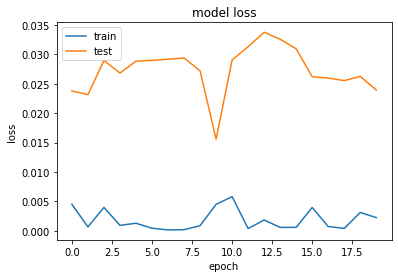

In [27]:
%matplotlib inline
from matplotlib import pyplot
test_acc_bi_lstm = model.evaluate((x_test_Article_pad, x_test_Title_pad, x_test_Author_pad), y_test, verbose=0)
print("Traiing and validation loss")
print('Test loss: %.3f' % (test_acc_bi_lstm[0]))
# plot training history
print("Traiing and validation loss")
pyplot.plot(history.history['loss'], label='train LSTM')
pyplot.plot(history.history['val_loss'], label='test LSTM')
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Traiing and validation accuracy
Test accuracy: 1.000


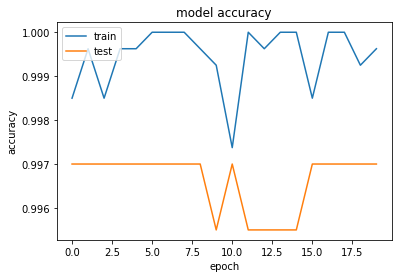

In [28]:

%matplotlib inline
print("Traiing and validation accuracy")
print('Test accuracy: %.3f' % ( test_acc_bi_lstm[1]))
pyplot.plot(history.history['accuracy'], label='train LSTM')
pyplot.plot(history.history['val_accuracy'], label='test LSTM')
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()